In [1]:
import os
import json
import numpy as np
from PIL import Image


In [2]:
data_root = '/datas/K-Hairstyle-Filtered/Training/rawset'
data_source = 'K-Hairstyle/Training'
print('data_root', data_root)
print('data_source', data_source)


data_root /datas/K-Hairstyle-Filtered/Training/rawset
data_source K-Hairstyle/Training


In [3]:
align_images_dir = os.path.join(data_root, 'align_images')
align_parsing_dir = os.path.join(data_root, 'align_parsing')
head_images_dir = os.path.join(data_root, 'head_images')
head_parsing_dir = os.path.join(data_root, 'head_parsing')
assert os.path.exists(align_images_dir)
assert os.path.exists(align_parsing_dir)
assert os.path.exists(head_images_dir)
assert os.path.exists(head_parsing_dir)

meta_files = [i for i in os.listdir(data_root) if i.endswith('.json') and i.startswith('meta')]
meta_files = sorted(meta_files, key=lambda x: int(x.split('_')[1].split('.')[0].split('-')[0]))
print(meta_files)

['meta_1-12.json', 'meta_2-12.json', 'meta_3-12.json', 'meta_4-12.json', 'meta_5-12.json', 'meta_6-12.json', 'meta_7-12.json', 'meta_8-12.json', 'meta_9-12.json', 'meta_10-12.json', 'meta_11-12.json', 'meta_12-12.json']


In [4]:
def get_cam_coords(c2w):
    # World Coordinate System: x(right), y(up), z(forward)
    T = c2w[:3, 3]
    x, y, z = T
    r = np.sqrt(x**2+y**2+z**2)
    # theta = np.rad2deg(np.arctan(np.sqrt(x**2+z**2)/y))
    theta = np.rad2deg(np.arctan2(x, z))
    if theta >= -90 and theta <= 90:
        theta += 90
    elif theta>=-180 and theta < -90:
        theta += 90
    elif theta>90 and theta <= 180:
        theta -= 270
    else:
        raise ValueError('theta out of range')
    # phi = np.rad2deg(np.arctan(z/x))+180
    phi = np.rad2deg(np.arccos(y/r))
    return [theta, phi, r, x, y, z] # [:3] sperical cood, [3:] cartesian cood

In [5]:
meta_idx = 0

print('meta_idx', meta_files[meta_idx])
with open(os.path.join(data_root, meta_files[meta_idx]), 'r') as f:
    cur_meta_data = json.load(f)

meta_idx meta_1-12.json


In [ ]:
# Merge 2-12 ~ 12-12 to one dict
# Run on remote server

In [6]:
cur_meta_data['images/0003.rawset/0001.가르마/0126.CP032677/CP032677-016.jpg']['data_source']

'K-Hairstyle/Training'

In [7]:
vis = True

import tqdm

for k in tqdm.tqdm(cur_meta_data.keys()):
    # print(k, cur_meta_data[k]['data_source'])
    if cur_meta_data[k]['data_source'] != data_source:
        cur_meta_data[k]['data_source'] = data_source
    for hk in cur_meta_data[k]['head'].keys():
        if cur_meta_data[k]['head'][hk]['camera'] is None:
            print('camera is None')
            del cur_meta_data[k]['head'][hk]
            continue
        cur_cam = cur_meta_data[k]['head'][hk]['camera']
        cur_TMatrix = np.array(cur_cam[:16]).reshape(4, 4)
        cur_cam_scoord = get_cam_coords(cur_TMatrix)
        cur_meta_data[k]['head'][hk]["camera_scoord"] = cur_cam_scoord
        # front [45, 135]
        # right [-45, 45]
        # back [-135, -45]
        # left [-180, -135], [135, 180]
        theta = cur_cam_scoord[0]
        if theta >= -45 and theta <= 45:
            cur_meta_data[k]['head'][hk]['view'] = 'right'
        elif theta >= 45 and theta <= 135:
            cur_meta_data[k]['head'][hk]['view'] = 'front'
        elif theta >= -135 and theta <= -45:
            cur_meta_data[k]['head'][hk]['view'] = 'back'
        else:
            cur_meta_data[k]['head'][hk]['view'] = 'left'
    if cur_meta_data[k]['head'] == {}:
        print('head is None')
        del cur_meta_data[k]
        continue

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:00<00:00, 63347.06it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

left


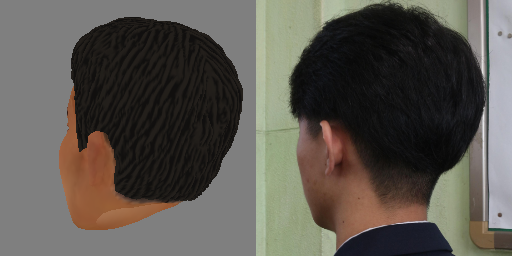

  0%|          | 1/10000 [00:00<1:51:03,  1.50it/s]

back


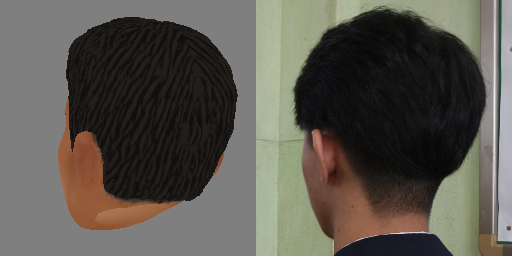

  0%|          | 2/10000 [00:01<1:30:04,  1.85it/s]

right


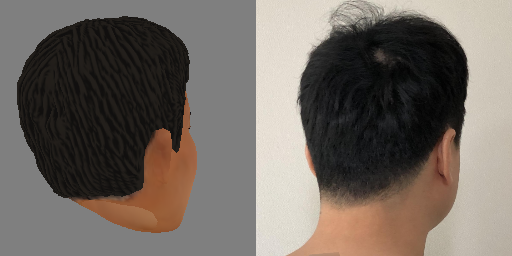

  0%|          | 19/10000 [00:01<12:00, 13.85it/s] 

front


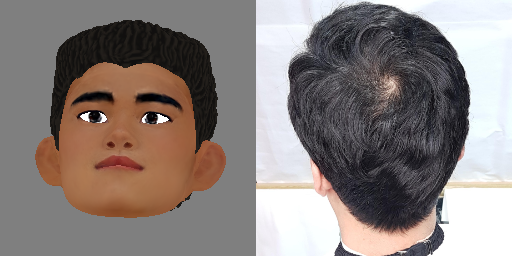

100%|██████████| 10000/10000 [00:02<00:00, 4066.92it/s]


In [8]:
front_flag = False
right_flag = False
back_flag = False
left_flag = False

import cv2
from utils.tool import render_camera

def show_render_check(cur_dt, data_root):
    cam = np.array(cur_dt['camera'])
    r_img = render_camera(cam)
    h, w = r_img.shape[:2]
    a_img = cv2.imread(os.path.join(data_root, cur_dt['align_image_path']))
    a_img = cv2.cvtColor(a_img, cv2.COLOR_BGR2RGB)
    a_img = cv2.resize(a_img, (h, w))
    vis_img = np.hstack([r_img, a_img])
    display(Image.fromarray(vis_img))

for k in tqdm.tqdm(cur_meta_data.keys()):
    assert cur_meta_data[k]['data_source'] == data_source
    for hk in cur_meta_data[k]['head'].keys():
        assert cur_meta_data[k]['head'][hk]['camera'] is not None
        cur_dt = cur_meta_data[k]['head'][hk]
        if not front_flag:
            if cur_dt['view'] == 'front':
                print(cur_dt['view'])
                show_render_check(cur_dt, data_root)
                front_flag = True
        if not right_flag:
            if cur_dt['view'] == 'right':
                print(cur_dt['view'])
                show_render_check(cur_dt, data_root)
                right_flag = True
        if not back_flag:
            if cur_dt['view'] == 'back':
                print(cur_dt['view'])
                show_render_check(cur_dt, data_root)
                back_flag = True
        if not left_flag:
            if cur_dt['view'] == 'left':
                print(cur_dt['view'])
                show_render_check(cur_dt, data_root)
                left_flag = True

In [9]:
with open(os.path.join(data_root, meta_files[meta_idx]), 'w') as f:
    json.dump(cur_meta_data, f, indent=4)

In [10]:
export_dir = '/data1/chence/PanoHeadData/ExportedSV'
os.makedirs(export_dir, exist_ok=True)

export_align_images_dir = os.path.join(export_dir, 'align_images')
export_align_parsing_dir = os.path.join(export_dir, 'align_parsing')
export_head_images_dir = os.path.join(export_dir, 'head_images')
export_head_parsing_dir = os.path.join(export_dir, 'head_parsing')
os.makedirs(export_align_images_dir, exist_ok=True)
os.makedirs(export_align_parsing_dir, exist_ok=True)
os.makedirs(export_head_images_dir, exist_ok=True)
os.makedirs(export_head_parsing_dir, exist_ok=True)

export_start_idx = 199819+10014
export_meta_json = os.path.join(export_dir, f'meta_{export_start_idx:07d}.json')
export_meta_dict = {}


In [11]:
export_meta_json

'/data1/chence/PanoHeadData/ExportedSV/meta_0199819.json'

In [12]:
for k in tqdm.tqdm(cur_meta_data.keys()):
    for hk in cur_meta_data[k]['head'].keys():
        export_folder = str(export_start_idx // 1000).zfill(5)
        export_name = 'img'+str(export_start_idx).zfill(8)+'.png'
        export_key = f'{export_folder}/{export_name}'
        export_meta_dict[export_key] = {'data_source': data_source}
        export_meta_dict[export_key].update(cur_meta_data[k]['head'][hk])
        export_start_idx += 1

100%|██████████| 10000/10000 [00:00<00:00, 263779.43it/s]


In [13]:
def work(export_key, data_item, data_root, export_align_images_dir, export_align_parsing_dir, export_head_images_dir, export_head_parsing_dir):
    try:
        export_folder = export_key.split('/')[0]
        export_align_image_folder = os.path.join(export_align_images_dir, export_folder)
        export_align_parsing_folder = os.path.join(export_align_parsing_dir, export_folder)
        export_head_image_folder = os.path.join(export_head_images_dir, export_folder)
        export_head_parsing_folder = os.path.join(export_head_parsing_dir, export_folder)
        os.makedirs(export_align_image_folder, exist_ok=True)
        os.makedirs(export_align_parsing_folder, exist_ok=True)
        os.makedirs(export_head_image_folder, exist_ok=True)
        os.makedirs(export_head_parsing_folder, exist_ok=True)

        export_align_image_path = os.path.join(export_align_images_dir, export_key)
        export_align_parsing_path = os.path.join(export_align_parsing_dir, export_key)
        export_head_image_path = os.path.join(export_head_images_dir, export_key)
        export_head_parsing_path = os.path.join(export_head_parsing_dir, export_key)

        cur_align_image_path = os.path.join(data_root, data_item['align_image_path'])
        assert os.path.exists(cur_align_image_path)
        if cur_align_image_path.endswith('.png') or cur_align_image_path.endswith('.PNG'):
            os.system(f'cp {cur_align_image_path} {export_align_image_path}')
        else:
            cur_align_image_data = cv2.imread(cur_align_image_path)
            cv2.imwrite(export_align_image_path, cur_align_image_data)

        cur_align_parsing_path = os.path.join(data_root, data_item['align_parsing_path'])
        assert os.path.exists(cur_align_parsing_path)
        assert cur_align_parsing_path.endswith('.png') or cur_align_parsing_path.endswith('.PNG')
        os.system(f'cp {cur_align_parsing_path} {export_align_parsing_path}')

        cur_head_image_path = os.path.join(data_root, data_item['head_image_path'])
        assert os.path.exists(cur_head_image_path)
        if cur_head_image_path.endswith('.png') or cur_head_image_path.endswith('.PNG'):
            os.system(f'cp {cur_head_image_path} {export_head_image_path}')
        else:
            cur_head_image_data = cv2.imread(cur_head_image_path)
            cv2.imwrite(export_head_image_path, cur_head_image_data)

        cur_head_parsing_path = os.path.join(data_root, data_item['head_parsing_path'])
        assert os.path.exists(cur_head_parsing_path)
        assert cur_head_parsing_path.endswith('.png') or cur_head_parsing_path.endswith('.PNG')
        os.system(f'cp {cur_head_parsing_path} {export_head_parsing_path}')
    except Exception as e:
        print(e)

In [14]:
import multiprocessing as mp
import cv2

global progress_bar
progress_bar = tqdm.tqdm(total=len(export_meta_dict))

def update_progress_bar(_):
    progress_bar.update()

pool = mp.Pool(processes=64)
for k, v in export_meta_dict.items():
    pool.apply_async(work, (
        k,
        v,
        data_root,
        export_align_images_dir,
        export_align_parsing_dir,
        export_head_images_dir,
        export_head_parsing_dir,
    ), callback=update_progress_bar)
pool.close()
pool.join()
progress_bar.close()

100%|██████████| 10014/10014 [44:39<00:00,  3.74it/s] 


In [15]:
with open(export_meta_json, 'w') as f:
    json.dump(export_meta_dict, f, indent=4)

In [16]:
print(len(export_meta_dict))

10014


In [17]:
print('export_start_idx', export_start_idx)

export_start_idx 209833


In [37]:
import os.path as osp

export_dir = '/data1/chence/PanoHeadData/ExportedMV'
os.makedirs(export_dir, exist_ok=True)

export_align_images_dir = os.path.join(export_dir, 'align_images')
export_align_parsing_dir = os.path.join(export_dir, 'align_parsing')
export_head_images_dir = os.path.join(export_dir, 'head_images')
export_head_parsing_dir = os.path.join(export_dir, 'head_parsing')
os.makedirs(export_align_images_dir, exist_ok=True)
os.makedirs(export_align_parsing_dir, exist_ok=True)
os.makedirs(export_head_images_dir, exist_ok=True)
os.makedirs(export_head_parsing_dir, exist_ok=True)

export_start_idx = 10014
export_meta_json = os.path.join(export_dir, f'meta_{export_start_idx:07d}.json')
export_meta_dict = {}
export_instance_json = os.path.join(export_dir, 'instance.json')
if osp.exists(export_instance_json):
    with open(export_instance_json, 'r') as f:
        export_instance_dict = json.load(f)
else:
    export_instance_dict = {}

In [38]:
export_meta_json

'/data1/chence/PanoHeadData/ExportedMV/meta_0000000.json'

In [39]:
instance_keys = []
for k in tqdm.tqdm(cur_meta_data.keys()):
    image_name = osp.basename(k)
    image_dir = osp.dirname(k)
    dtsrc = cur_meta_data[k]['data_source']
    instance_key = f'{dtsrc}/{image_dir}'
    instance_keys.append(instance_key)

instance_idx = len(export_instance_dict)
instance_keys = sorted(list(set(instance_keys)))
for instance_key in instance_keys:
    export_instance_dict[instance_key] = str(instance_idx).zfill(5)
    instance_idx += 1

100%|██████████| 10000/10000 [00:00<00:00, 295775.53it/s]


In [43]:
instance_image_idx = {}
for k in tqdm.tqdm(cur_meta_data.keys()):
    for hk in cur_meta_data[k]['head'].keys():
        image_name = osp.basename(k)
        image_dir = osp.dirname(k)
        dtsrc = cur_meta_data[k]['data_source']
        instance_key = f'{dtsrc}/{image_dir}'
        export_folder = export_instance_dict[instance_key]
        if export_folder not in instance_image_idx.keys():
            instance_image_idx[export_folder] = 0
        export_name = 'img'+str(instance_image_idx[export_folder]).zfill(8)+'.png'
        instance_image_idx[export_folder] += 1
        export_key = f'{export_folder}/{export_name}'
        export_meta_dict[export_key] = {'data_source': data_source}
        export_meta_dict[export_key].update(cur_meta_data[k]['head'][hk])
        export_start_idx += 1

100%|██████████| 10000/10000 [00:00<00:00, 119462.83it/s]


In [53]:
import multiprocessing as mp
import cv2

global progress_bar
progress_bar = tqdm.tqdm(total=len(export_meta_dict))

def update_progress_bar(_):
    progress_bar.update()

pool = mp.Pool(processes=64)
for k, v in export_meta_dict.items():
    pool.apply_async(work, (
        k,
        v,
        data_root,
        export_align_images_dir,
        export_align_parsing_dir,
        export_head_images_dir,
        export_head_parsing_dir,
    ), callback=update_progress_bar)
pool.close()
pool.join()
progress_bar.close()

100%|██████████| 10014/10014 [38:26<00:00,  4.34it/s] 


In [54]:
with open(export_meta_json, 'w') as f:
    json.dump(export_meta_dict, f, indent=4)

with open(export_instance_json, 'w') as f:
    json.dump(export_instance_dict, f, indent=4)

In [55]:
print(len(export_meta_dict))

10014


In [56]:
print('export_start_idx', export_start_idx)

export_start_idx 10014
